In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#setup figure styles
plt.style.use(['default'])
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
dipcmap = plt.get_cmap("RdYlGn_r")

In this notebook we load and then upscale the Schmidt hammer and literature data for strong (basaltic dyke) and weak (pyroclastic tuffs and volcanic breccia) host rock lithologies.

### 1. Schmidt hammer data
First, we load our schmidt hammer dataset and convert these to estimated stiffness (E) and unconfined compressive strength (UCS).

In [4]:
# load Schmidt hammer data and plot
schmidt = pd.read_excel('schmidt_rebound.xlsx', sheet_name='Transposed')

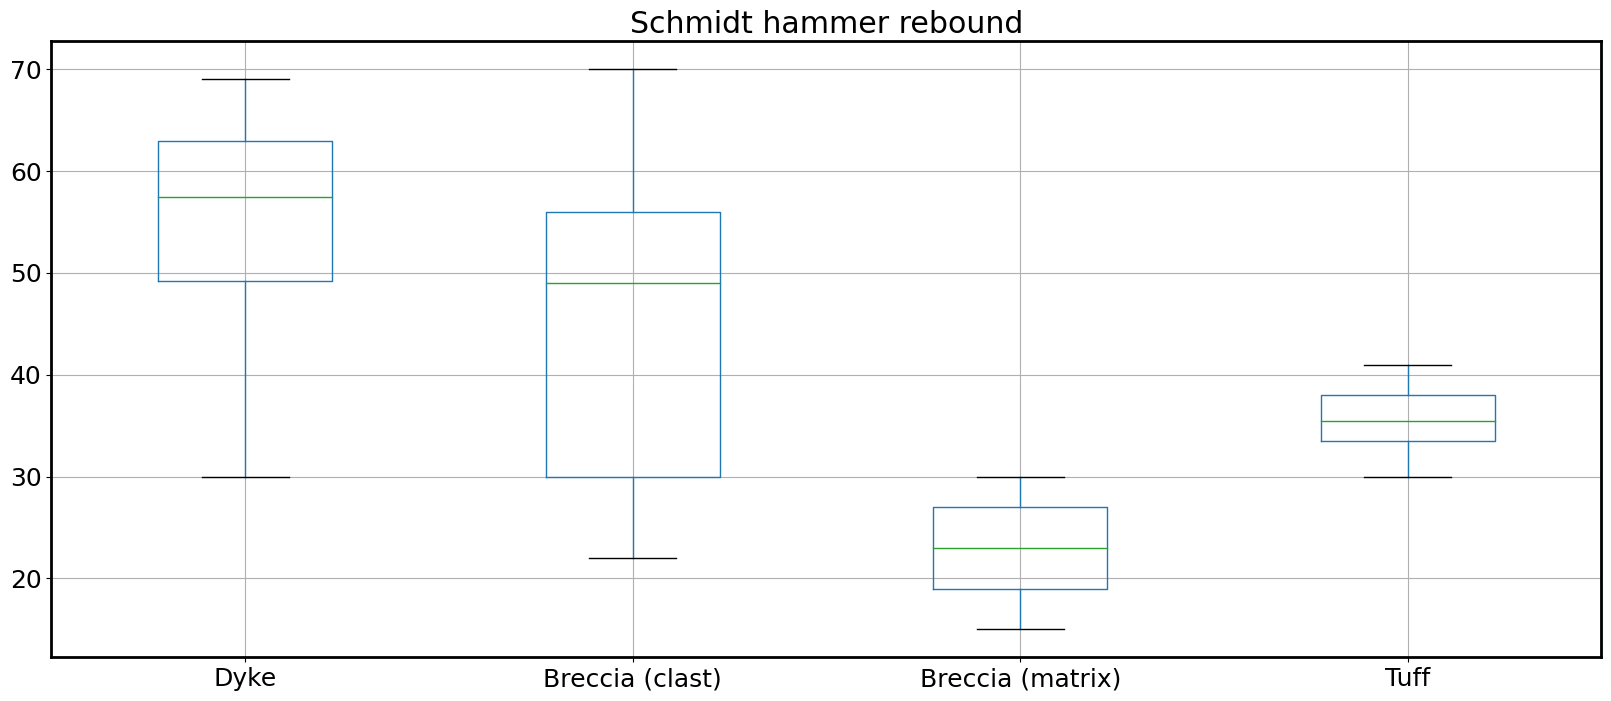

In [5]:
plt.figure(figsize=(20,8))
schmidt.boxplot()
plt.gca().set_title("Schmidt hammer rebound")
plt.show()

Using the empirical relationship defined by by [Dincer et al., 2004](https://link.springer.com/article/10.1007/s10064-004-0230-0) using data for volcanic rocks (basalt, andesite and tuff) we can derive rough estimates for E and UCS:

$$
E = 0.47N - 6.25 \quad (R^2 = 0.85)
$$

$$
UCS = 2.75N-36.83 \quad (R^2 = 0.95)
$$

Note though that these estimates are not statistically independent (as they are both linear transforms of the same rebound measurements), limiting their usefulness for our purpose (comparing ratios of stiffness and strength).

In [6]:
E = schmidt * 0.47 - 6.25
UCS = schmidt * 2.75 - 36.83

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_43008/760414424.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


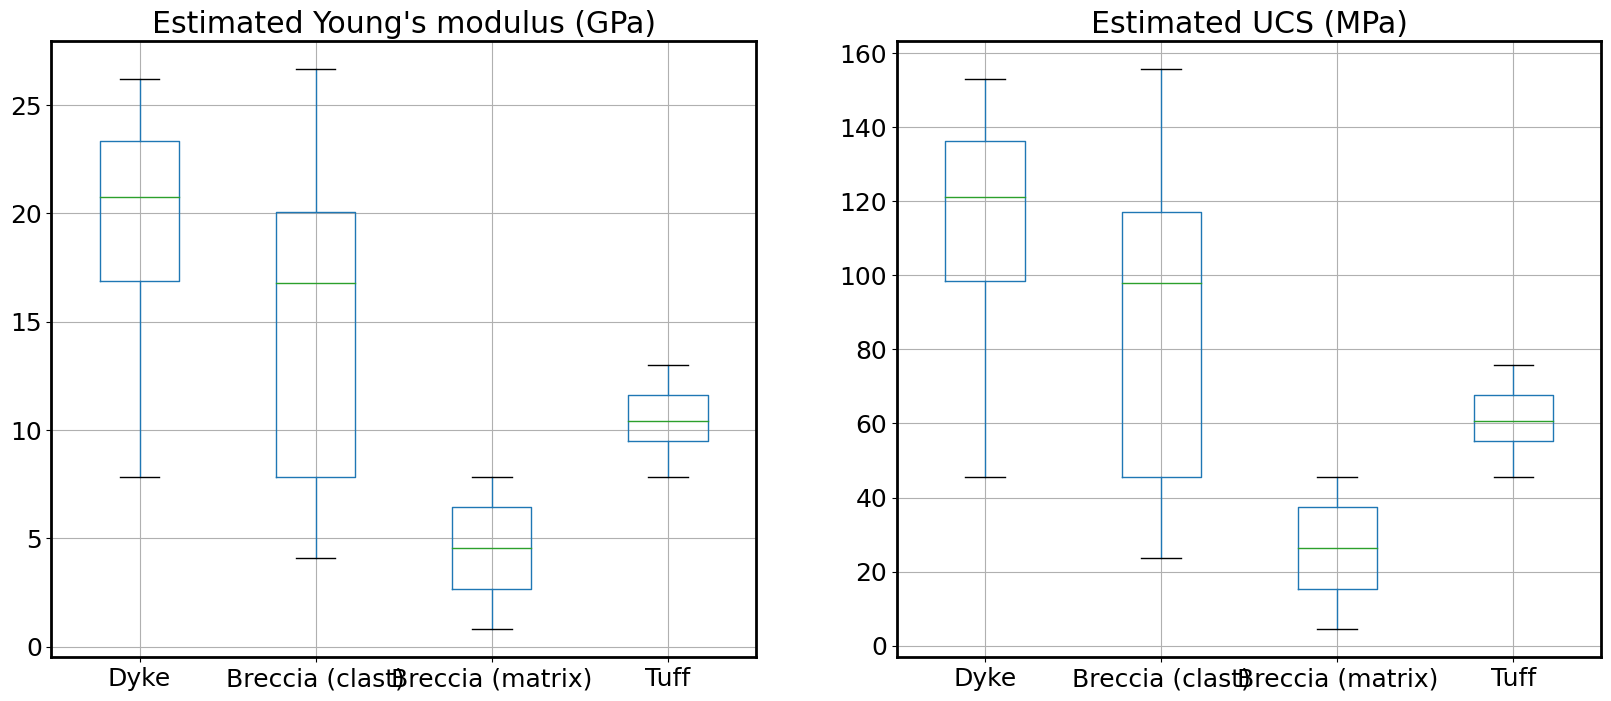

In [7]:
fig,ax = plt.subplots(1,2,figsize=(20,8))
E.boxplot(ax=ax[0])
UCS.boxplot(ax=ax[1])
ax[0].set_title("Estimated Young's modulus (GPa)")
ax[1].set_title("Estimated UCS (MPa)")
fig.show()

### 2. Literature data

Given the limitations of the Schmidt hammer data (statistical dependance and errors associated with the empirical correlation), we also use data derived from uniaxial compressive tests by [](), [Seisdedos et al., 2012](https://digital.csic.es/bitstream/10261/276872/1/geological_geomechanical_models_2012.pdf) and [Potro & Hürlimann, 2008](https://www.sciencedirect.com/science/article/abs/pii/S0013795207002475).

In [8]:
# load data on dyke (basalts) and host-rock (tuff) lithologies
dyke = pd.read_excel('rockproperties.xlsx', sheet_name='Basalts')
host = pd.read_excel('rockproperties.xlsx', sheet_name='Pyroclastics')

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_43008/1870755520.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


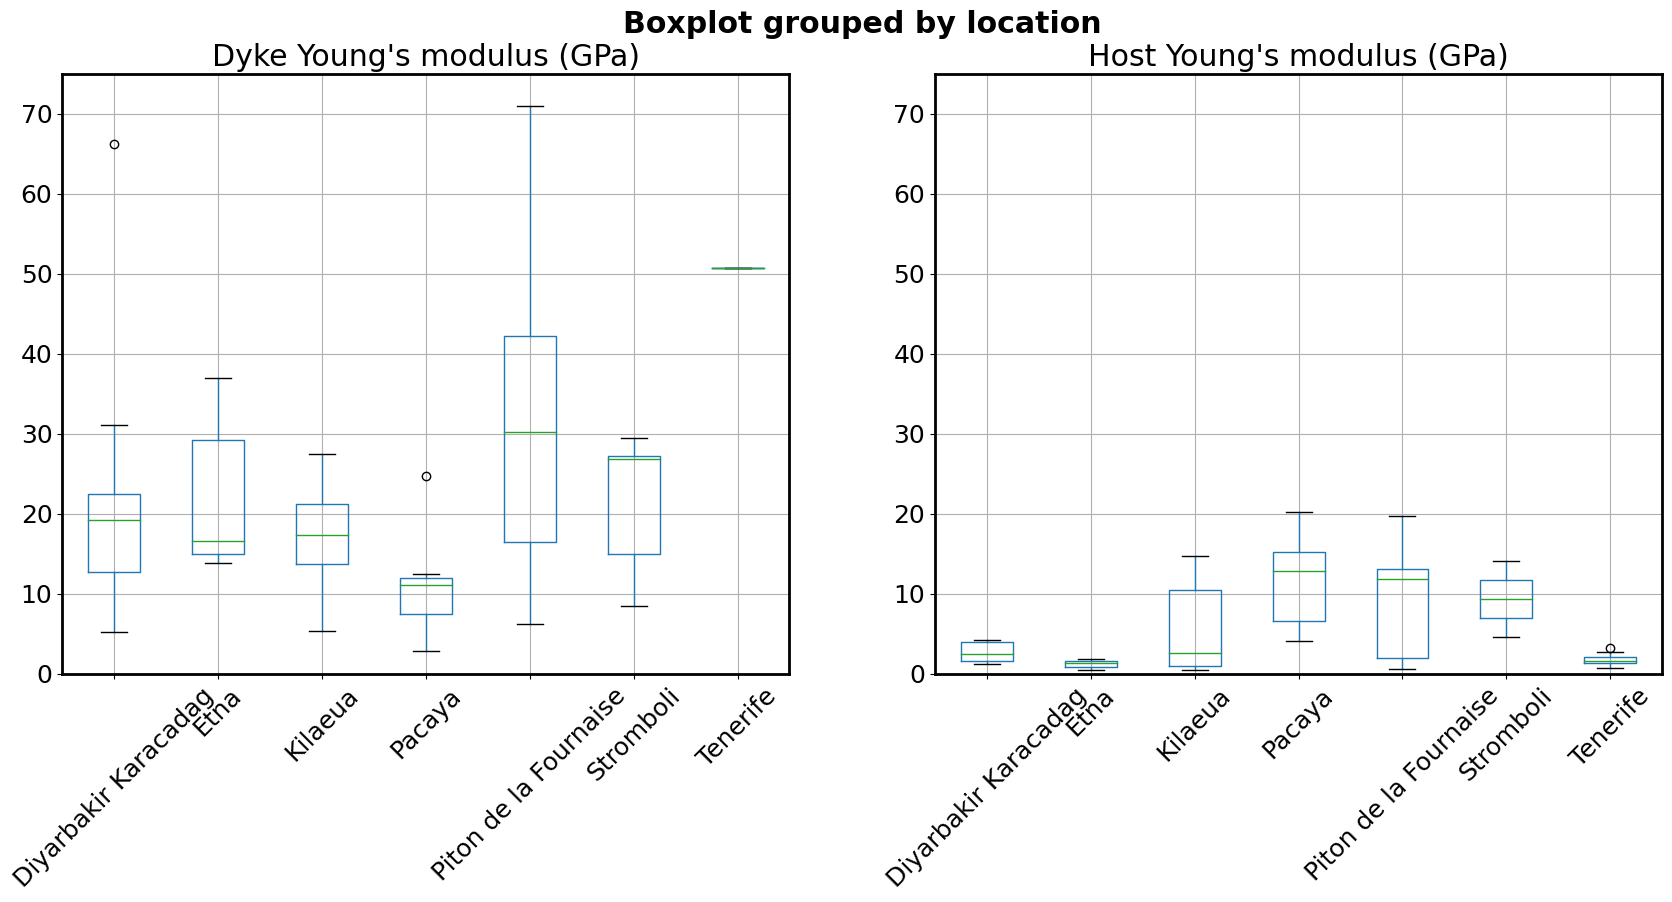

In [9]:
fig,ax = plt.subplots(1,2,figsize=(20,8))
dyke.boxplot(column='E',by='location', ax=ax[0])
host.boxplot(column='E',by='location', ax=ax[1])
ax[0].set_title("Dyke Young's modulus (GPa)")
ax[1].set_title("Host Young's modulus (GPa)")
for a in ax:
    a.set_xticklabels(ax[0].get_xticklabels(), rotation=45)
    a.set_xlabel('')
    a.set_ylim(0,75)
fig.show()

In [10]:
# aggregate data by location and sammple type
dyke = dyke.groupby(by=['location','type']).mean()
host = host.groupby(by=['location','type']).mean()

### 3. Upscaling

Finally, we use the empirical Hoek-Brown and Hoek-Diederichs equations to scale the intact rock properties above to fractured rock mass properties, based on the geological strength index (GSI).

As the basaltic dykes are generally crosscut by cooling and/or margin-parallel joints, we give them a GSI of 65. Published values for GSI in tuffs vary significantly (from ~20 to ~80), but we consider the Tuff's on La Palma to be generally quite intact rock masses (they are welded and crosscut by sparse joints): hence we use a GSI of 75 for these.

The Hoek-Brown equation also requries a fitting parameter (*mb*), which we set as 10 for the tuff and 25 for the dykes, following [Potro & Hürlimann, 2008](https://www.sciencedirect.com/science/article/abs/pii/S0013795207002475).

In [11]:
# Hoek-Brown parameteres for intact basalt (dyke) and pyroclastic rock (host) from Potro and Hurlimann 2008
host_GSI = 75 
dyke_GSI = 65
host_mi = 10
dyke_mi = 25

# rough density (for estimating stress at depth)
rho = 2500
z = 500 # depth in m
S1 = (rho * 8.8 * z) / 1e6
S3 = ( (rho * 9.8 * z) / 3) / 1e6 # horizontal stress at depth is ~ 1/3rd of vertical stress
print('Lithostatic Vertical stress is: ', S1, ' MPa')
print('Lithostatic horizontal stress is: ', S3, ' MPa')

Lithostatic Vertical stress is:  11.0  MPa
Lithostatic horizontal stress is:  4.083333333333334  MPa


In [12]:
def hoek_brown( S3, ucs, E, mi, GSI, v=0.25 ):
    """
    Compute failure stress (S1) and effective shear modulus (G_m) for a given rock-mass.
    """
    mb = mi * np.exp((GSI-100)/28)
    s = np.exp((GSI-100)/9)
    a = (1/2.) + (1/6.)*(np.exp(-GSI/15) - np.exp(-20/3))
    
    # compute maximum principal stress (S1) at failure following Hoek Brown
    S1 = S3+ucs*(mb*(S3/ucs)+s)**a
    t_max = 0.5 * (S1 - S3) # compute maximum shear stress at failure (shear strength)
    
    # compute scaled elastic properties [Hoek-Diederichs equation]
    E = E*(0.02+(1/(1+np.exp((60-GSI)/11))))
    G = 0.5 * (E / (1+v) )
    
    # convert t
    #return S1, E
    return t_max, G

Do the upscaling and report for representative host and dyke values and print results, assuming 1000 m slope heights.

In [13]:
# apply to in-situ test data from Heap et al.,
# for basalts (dykes)
G_rm = []
S_rm = []
for i in range(dyke.shape[0]):
    _S_rm, _G_rm = hoek_brown( S3, 
                               dyke['UCS'][i], 
                               dyke['E'][i], 
                               dyke_mi, dyke_GSI )
    G_rm.append(_G_rm)
    S_rm.append(_S_rm)
dyke['G_rm'] = G_rm
dyke['S_rm'] = S_rm

# apply to in-situ test data from Heap et al.,
# for pyroclastics (host-rock)
G_rm = []
S_rm = []
for i in range(host.shape[0]):
    _S_rm, _G_rm = hoek_brown( S3, 
                               host['UCS'][i], 
                               host['E'][i], 
                               host_mi, host_GSI )
    G_rm.append(_G_rm)
    S_rm.append(_S_rm)
host['G_rm'] = G_rm
host['S_rm'] = S_rm


In [14]:
# apply to estimates for La Palma from literature review (c.f. Table 1)
dyke_UCS = 121
dyke_E = 20

host_UCS = 18
host_E = 4

dyke_s_rm, dyke_G_rm = hoek_brown( S3, dyke_UCS, dyke_E, dyke_mi, dyke_GSI )
print("Scaled dyke properties: ")
print("  Shear modulus (G): %.1f GPa" % dyke_G_rm)
print("  Max shear stress at failure @ %d m: %.1f MPa" % (z,dyke_s_rm))

print("\n\t\t---\n")

host_s_rm, host_G_rm = hoek_brown( S3, host_UCS, host_E, host_mi, host_GSI )
print("Scaled host properties: ")
print("  Shear modulus (E): %.1f GPa" % host_G_rm)
print("  Max shear stress at failure @ %d m: %.1f MPa" % (z,host_s_rm))

print("\n\t\t---\n")


# compute and print rock-mass criticality at La Palma
host_S_rm, host_G_rm = hoek_brown(S3, host_UCS, host_E, host_mi, host_GSI)
dyke_S_rm, dyke_G_rm = hoek_brown(S3, dyke_UCS, dyke_E, dyke_mi, dyke_GSI)

criticality_coeff = (host_S_rm / dyke_S_rm) - (host_G_rm / dyke_G_rm)
print("Hoyo Verde rock-mass criticality: ", criticality_coeff)

Scaled dyke properties: 
  Shear modulus (G): 5.1 GPa
  Max shear stress at failure @ 500 m: 30.9 MPa

		---

Scaled host properties: 
  Shear modulus (E): 1.3 GPa
  Max shear stress at failure @ 500 m: 9.0 MPa

		---

Hoyo Verde rock-mass criticality:  0.03154071836025679


### 4. Criticality 

Now that we have estimates of shear strength and shear stiffness for dyke and host-rock lithologies we can explore the plausible range of criticality coefficients.


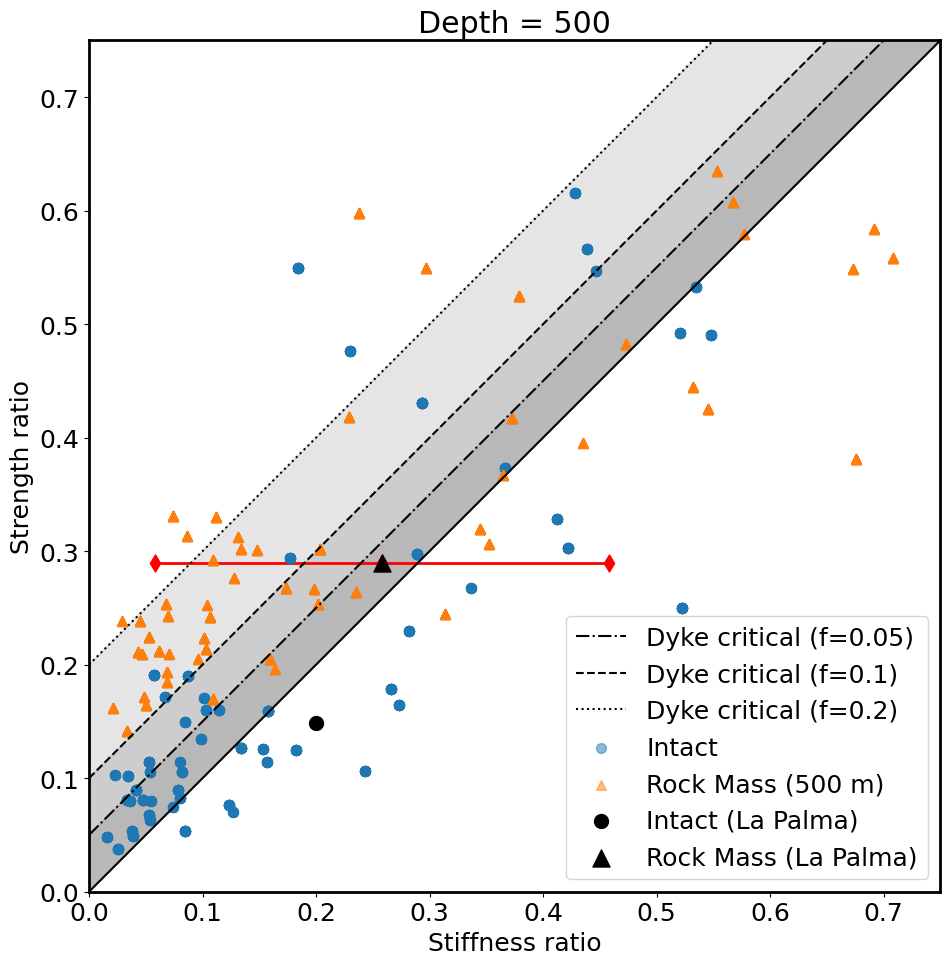

In [15]:
# randomly sample pairs of host and dyke properties
np.random.seed(42)
dyke_idx = np.random.choice(len(dyke), size=1000) # use large sample size to get most possible combinations
host_idx = np.random.choice(len(host), size=1000)

fig,a=plt.subplots(1,1,figsize=(10,10))    

a.set_xlabel('Stiffness ratio')
a.set_ylabel('Strength ratio')
a.set_title("Depth = %d" % z)
a.set_xlim(0., 0.75)
a.set_ylim(0., 0.75)

# get properties from data sheet
# note that we convert these to maximum shear stress
# at failure
dyke_strength = (np.array(dyke['UCS']) - 0) / 2. # maximum shear stress from UCS (N.B. S3 = 0 in UCS)
host_strength = (np.array(host['UCS']) - 0) / 2. # maximum shear stress from UCS (N.B. S3 = 0 in UCS)
dyke_stiffness = 0.5 * (np.array(dyke['E']) / (1+0.25) ) # shear modulus (G)
host_stiffness = 0.5 * (np.array(host['E']) / (1+0.25) ) # shear modulus (G)

dyke_strength_rm = np.array(dyke['S_rm']) # maximum shear stress derived from Hoek Brown S1 estimate
host_strength_rm = np.array(host['S_rm']) # maximum shear stress derived from Hoek Brown S1 estimate
dyke_stiffness_rm = np.array(dyke['G_rm'])
host_stiffness_rm = np.array(host['G_rm'])

# compute ratios
strength_ratio = np.array(host_strength[host_idx]) / np.array(dyke_strength[dyke_idx])
stiffness_ratio = np.array(host_stiffness[host_idx]) / np.array(dyke_stiffness[dyke_idx])

strength_ratio_rm = np.array(host_strength_rm[host_idx]) / np.array(dyke_strength_rm[dyke_idx])
stiffness_ratio_rm = np.array(host_stiffness_rm[host_idx]) / np.array(dyke_stiffness_rm[dyke_idx])

# plot
a.scatter(stiffness_ratio, strength_ratio, label='Intact', alpha=0.5, marker='o', s=50)
a.scatter(stiffness_ratio_rm, strength_ratio_rm, label='Rock Mass (%d m)'%z, alpha=0.5, marker='^', s=50)

# also add "representative properties"
a.scatter( (host_E / dyke_E), (host_UCS / dyke_UCS), label='Intact (La Palma)', alpha=1.0, marker='o', s=100, color='k')
a.scatter( (host_G_rm / dyke_G_rm), 
           (host_S_rm / dyke_S_rm), 
           label='Rock Mass (La Palma)', alpha=1.0, marker='^', s=150, color='k')

# and range of params trialed by FBM models
offs = [-0.2, 0., 0.2 ]
a.scatter([(host_G_rm / dyke_G_rm)-o for o in offs],
          [(host_S_rm / dyke_S_rm) for o in offs], color='red', marker='d', s=75, zorder=0)
a.plot([(host_G_rm / dyke_G_rm)-o for o in offs],
          [(host_S_rm / dyke_S_rm) for o in offs], color='red', lw=2, zorder=0 )


# and lastly, (upper) boundaries of the 'dyke critical' zone at different dyke fractions
a.plot([0,1],[0,1],color='k')
a.plot([0.0,1.0],[0.05,1.05],color='k', ls='-.', label='Dyke critical (f=0.05)')
a.fill([0,1,1,0],[0,1,1.05,0.05], color='k', alpha=0.1, zorder=-1)
a.plot([0.0,1.0],[0.1,1.1],color='k', ls='--', label='Dyke critical (f=0.1)')
a.fill([0,1,1,0],[0,1,1.1,0.1], color='k', alpha=0.1, zorder=-1 )
a.plot([0.0,1.0],[0.2,1.2],color='k', ls=':', label='Dyke critical (f=0.2)')
a.fill([0,1,1,0],[0,1,1.2,0.2], color='k', alpha=0.1, zorder=-1)


a.set_aspect('equal')
a.legend()
fig.tight_layout()

Note that dyke estimates from [Thiele et al., (2020)](https://www.nature.com/articles/s41598-020-74361-w) indicate that the fractured dykes observed at Hoyo Verde occupy ~5% of the rock mass, meaning the rock mass there is expected to be in or close to the dyke-critical regime. Note also the significant uncertainty the results when scaling from intact properties to rock-mass estimates. 

In the following we reproduce the above plot for Fig. 2 in the paper.

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_43008/1460912422.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


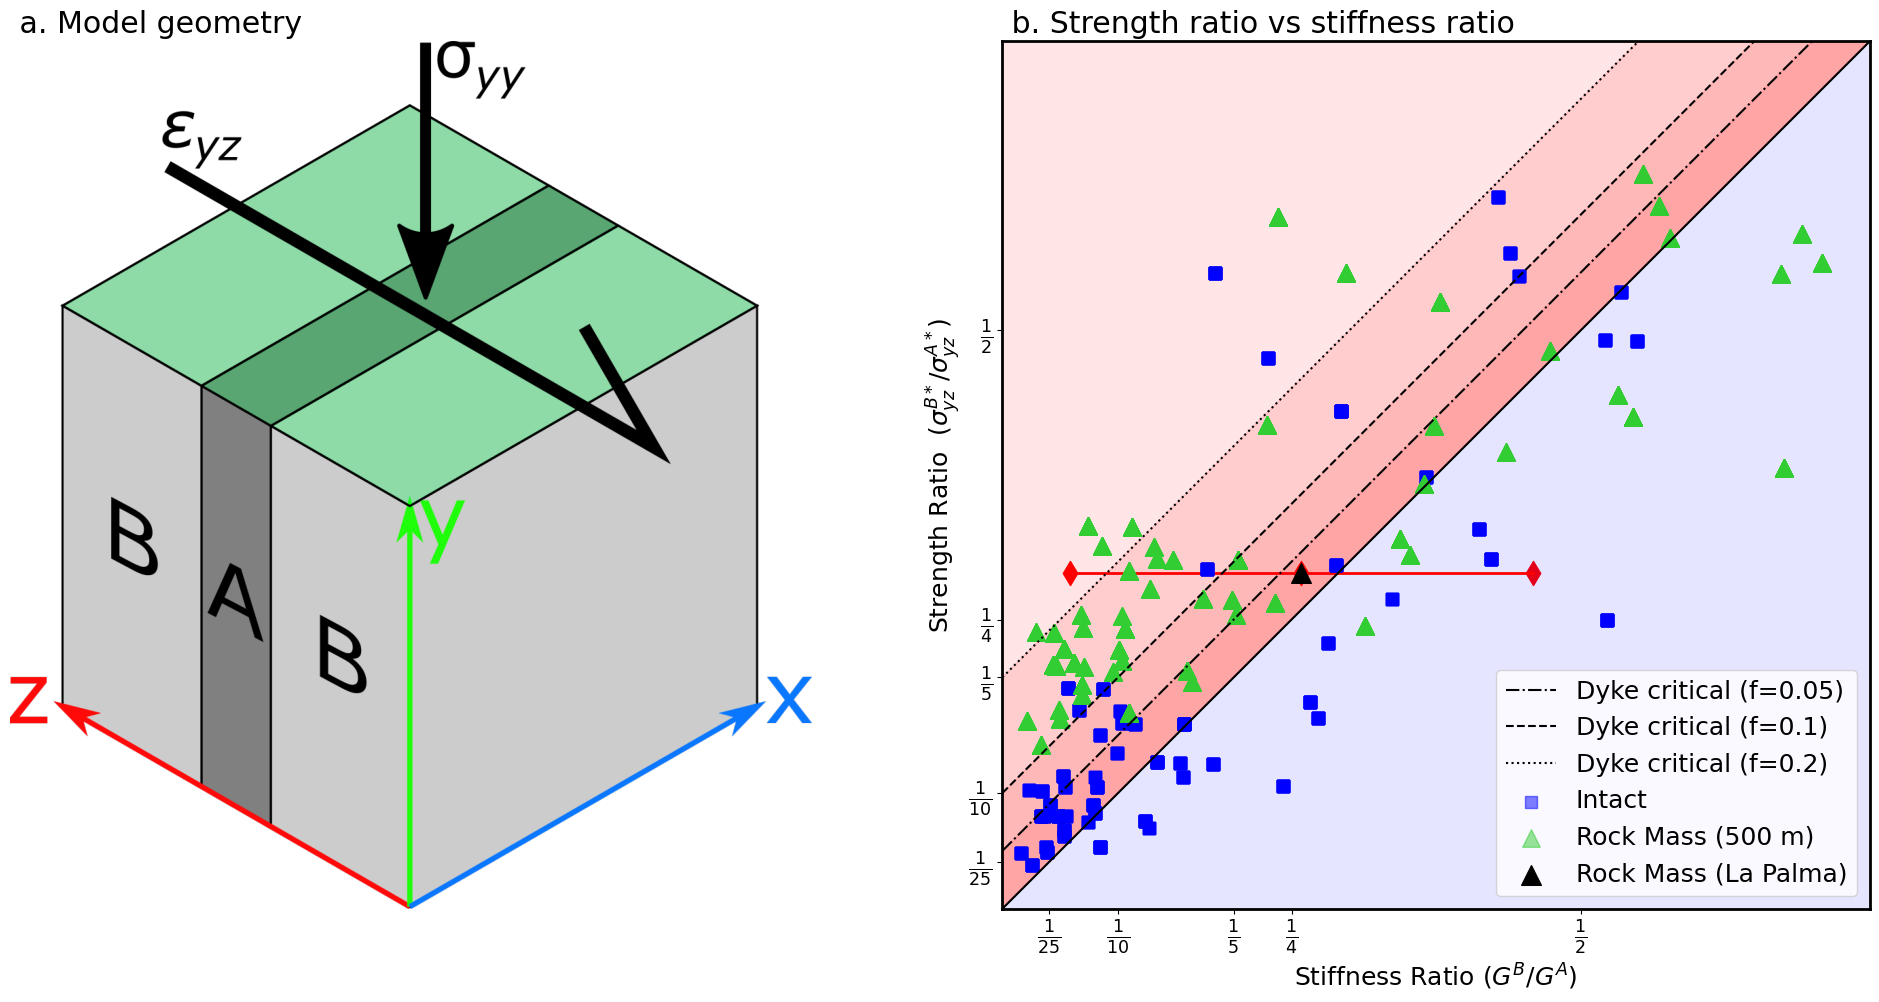

In [16]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax0,ax1 = ax

##########################################
##### a - Coordinate system #########
##########################################
img = plt.imread("coordinates.png")
ax0.imshow(img)
ax0.set_title(" a. Model geometry",loc = 'left')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.axis('off')

###########################################
# b - Strength ratio vs elastic ratio
###########################################
ax1.set_title(" b. Strength ratio vs stiffness ratio",loc = 'left')

#plot main domain boundaries
ax1.plot([0,1],[0,1],color='k', zorder=1)
ax1.fill([0,1,0,0],[0,1,1,0], color='red',alpha=0.1, zorder=0) # A-first domain
ax1.fill([0,1,1,0],[0,1,0,0], color='blue',alpha=0.1, zorder=0) # B-first domain

# plot (upper) boundaries of the 'dyke critical' zone at different dyke fractions
ax1.plot([0.0,1.0],[0.05,1.05],color='k', ls='-.', label='Dyke critical (f=0.05)', zorder=1)
ax1.fill([0,1,1,0],[0,1,1.05,0.05], color='r', alpha=0.1, zorder=0)
ax1.plot([0.0,1.0],[0.1,1.1],color='k', ls='--', label='Dyke critical (f=0.1)', zorder=1)
ax1.fill([0,1,1,0],[0,1,1.1,0.1], color='r', alpha=0.1, zorder=0 )
ax1.plot([0.0,1.0],[0.2,1.2],color='k', ls=':', label='Dyke critical (f=0.2)', zorder=1)
ax1.fill([0,1,1,0],[0,1,1.2,0.2], color='r', alpha=0.1, zorder=0)

# plot UCS test data
ax1.scatter(stiffness_ratio, 
            strength_ratio, 
            label='Intact', alpha=0.5, marker='s', s=80, color='blue')
ax1.scatter(stiffness_ratio_rm, 
            strength_ratio_rm, 
            label='Rock Mass (%d m)'%z, alpha=0.5, marker='^', s=160, color='limegreen')

# plot best-guess for La Palma
# ax1.scatter( (host_E / dyke_E), (host_UCS / dyke_UCS), label='Intact (La Palma)', alpha=1.0, marker='o', s=100, color='k')
ax1.scatter( (host_G_rm / dyke_G_rm), 
           (host_S_rm / dyke_S_rm), 
           label='Rock Mass (La Palma)', alpha=1.0, marker='^', s=200, color='k')

# and range of params trialed by FBM models
offs = [-0.2, 0., 0.2 ]
ax1.scatter([(host_G_rm / dyke_G_rm)-o for o in offs],
          [(host_S_rm / dyke_S_rm) for o in offs], color='red', marker='d', s=150, zorder=0)
ax1.plot([(host_G_rm / dyke_G_rm)-o for o in offs],
          [(host_S_rm / dyke_S_rm) for o in offs], color='red', lw=2, zorder=0 )

# labels and legends
ax1.set_xlim(0., 0.75)
ax1.set_ylim(0.,0.75)
ax1.set_xticks([1/25,1/10,1/5, 1/4, 1/2])
ax1.set_xticklabels([r"$\frac{1}{25}$",r"$\frac{1}{10}$",r"$\frac{1}{5}$",r"$\frac{1}{4}$",r"$\frac{1}{2}$"])
ax1.set_yticks([1/25,1/10,1/5, 1/4, 1/2])
ax1.set_yticklabels([r"$\frac{1}{25}$",r"$\frac{1}{10}$",r"$\frac{1}{5}$",r"$\frac{1}{4}$",r"$\frac{1}{2}$"])
ax1.set_aspect('equal')
ax1.set_xlabel(r"Stiffness Ratio $(G^B/G^A)$")
ax1.set_ylabel(r"Strength Ratio  $(\sigma^{B*}_{yz}/\sigma^{A*}_{yz})$")
ax1.legend()

fig.tight_layout()
fig.show()

#### 4. Validation

These theoretical predictions were partially validated by conducting a series of numerical compression tests in the Irazu FEM-DEM simulation software. The resulting stress-strain curves are plotted below for reference.

In [17]:
path = "irazu_models"

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_43008/2215736258.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


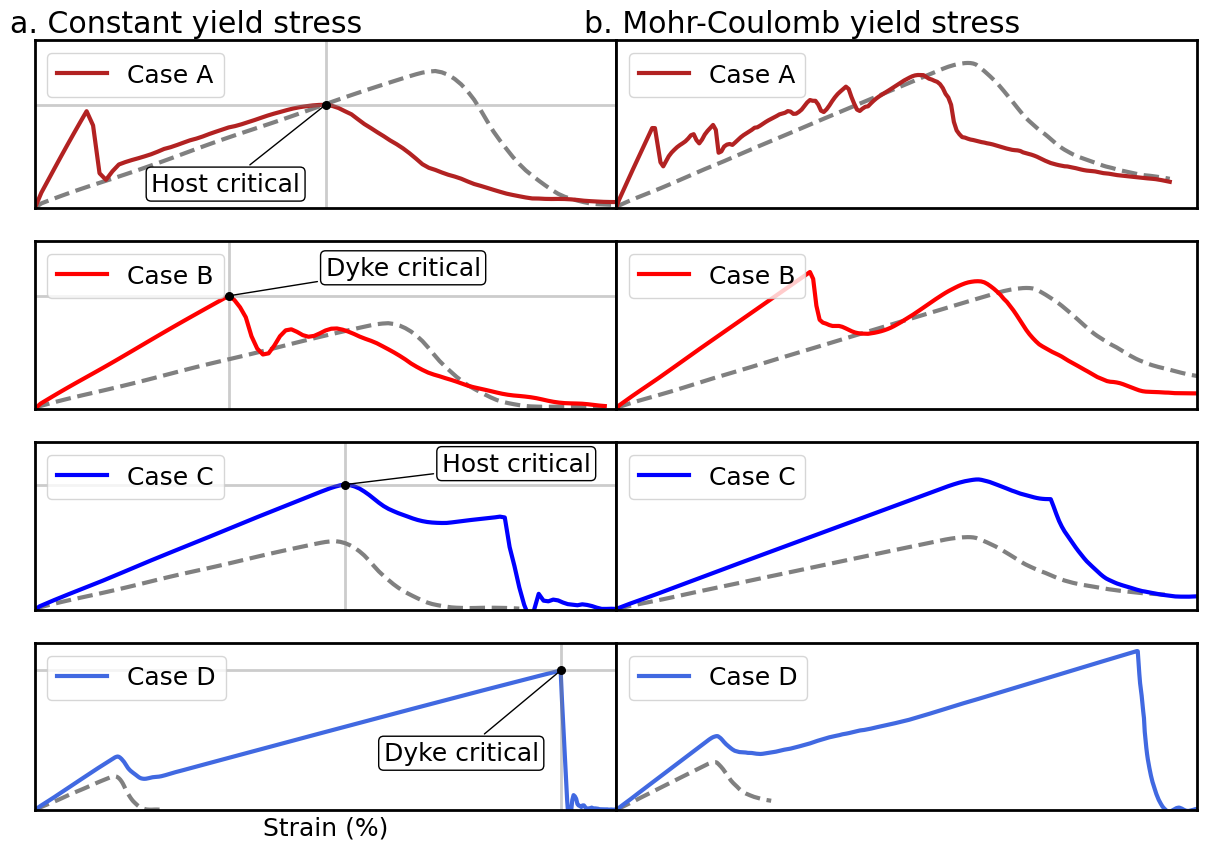

In [18]:

#setup figure
fig = plt.figure(figsize=(15,10))
ax2 = plt.subplot2grid((4, 2), (0, 0) ) #curve A
ax3 = plt.subplot2grid((4, 2), (1, 0) ) #curve B
ax4 = plt.subplot2grid((4, 2), (2, 0) ) #curve C
ax5 = plt.subplot2grid((4, 2), (3, 0) ) #curve D
ax6 = plt.subplot2grid((4, 2), (0, 1) ) #curve A
ax7 = plt.subplot2grid((4, 2), (1, 1) ) #curve B
ax8 = plt.subplot2grid((4, 2), (2, 1) ) #curve C
ax9 = plt.subplot2grid((4, 2), (3, 1) ) #curve D

#load and plot loading curves
curvesY=[np.load(path+'/YieldStress/Control_stress_strain.npy'),
        np.load(path+'/YieldStress/A_stress_strain.npy'),
        np.load(path+'/YieldStress/B_stress_strain.npy'),
        np.load(path+'/YieldStress/C_stress_strain.npy'),
        np.load(path+'/YieldStress/D_stress_strain.npy')]
curvesMC=[np.load(path+'/MohrCoulomb/Control_stress_strain.npy'),
        np.load(path+'/MohrCoulomb/A_stress_strain.npy'),
        np.load(path+'/MohrCoulomb/B_stress_strain.npy'),
        np.load(path+'/MohrCoulomb/C_stress_strain.npy'),
        np.load(path+'/MohrCoulomb/D_stress_strain.npy')]


#clip C curve
colors = ['firebrick', 'red', 'blue', 'royalblue']
labels = ["Case A","Case B","Case C","Case D"]
annots = ["Host critical","Dyke critical","Host critical","Dyke critical"]
annot_loc = [(0.2,0.1),(0.5,0.8),(0.7,0.83),(0.6,0.3)]
bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=1)
xlims = [0.15,0.17,0.2,0.75, 0.35,0.3,0.35,1.25]
ylims = [2.5,4,5,10,5,6,10,15]
for i,ax in enumerate([ax2,ax3,ax4,ax5]):
    ax.plot(curvesY[0][1]*100,curvesY[0][0]/1e6,color='gray',linestyle='--',lw=3) #reference curve
    ax.plot(curvesY[i+1][1]*100,curvesY[i+1][0]/1e6,color=colors[i],linestyle='-',lw=3,label=labels[i]) #loading curve
    idxmax = np.argmax(curvesY[i+1][0])
    ax.scatter(curvesY[i+1][1][idxmax]*100,curvesY[i+1][0][idxmax]/1e6,s=30,color='k',zorder=10)
    ax.axhline(curvesY[i+1][0][idxmax]/1e6,color='gray',alpha=0.4,lw=2)
    ax.axvline(curvesY[i+1][1][idxmax]*100,color='gray',alpha=0.4,lw=2)
    ax.annotate(annots[i],(curvesY[i+1][1][idxmax]*100,curvesY[i+1][0][idxmax]/1e6),
                xytext=annot_loc[i],textcoords=ax.transAxes,
                arrowprops=dict(arrowstyle='-'),bbox=bbox_props)
for i,ax in enumerate([ax6,ax7,ax8,ax9]):
    ax.plot(curvesMC[0][1]*100,curvesMC[0][0]/1e6,color='gray',linestyle='--',lw=3) #reference curve
    ax.plot(curvesMC[i+1][1]*100,curvesMC[i+1][0]/1e6,color=colors[i],linestyle='-',lw=3,label=labels[i])
for i,ax in enumerate([ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0,xlims[i])
    ax.set_ylim(0,ylims[i])
    ax.legend(loc='upper left')
    
ax2.set_title("a. Constant yield stress",x=0.26)
ax6.set_title("b. Mohr-Coulomb yield stress",x=0.32)
ax5.set_xlabel("Strain (%)")
fig.subplots_adjust(hspace=0.2, wspace=0)
fig.show()

#### 5. Linear-elastic fibre-bundle models

Fibre bundle models (FBMs) can be used to explore the failure of materials with stochastically distributed weakenesses, and can reproduce some of the non-linear weakening characteristics of real materials.

In the following we implement several different FBMs to characterise the stress - strain relationship of different dyke - hostrock composites under imposed shear stress.

In [19]:
class FBM( object ):
    """
    A class for constructing, running and storing results from 
    FBM models of dyke-host composite materials.
    """

    def __init__( self, dyke_props, host_props, f=0.1, N=10000, seed=42 ):
        """
        Construct a 2-component stress-controlled fiber bundle model assuming linear-elastic behaviour 
        and a mohr-coulomb failure envelope. Exponent **a** allows fibers to have residual stiffness 
        (if it is > 0). All units are in Pa. 

        **Arguments**:
         - dyke_props = a dictionary containing the dyke properties. 
         - host_props = a dictionary containing the host properties.
         - f = the volume fraction of dykes.
         - N = the number of fibres in the bundle.
        """
        
        # store params
        self.dyke_props = dyke_props
        self.host_props = host_props
        self.N = N
        self.nA = nA = int(N*f)
        self.f = f
        
        # get material constants
        self.G_A = G_A = dyke_props['G'] # shear stiffness
        self.G_B = G_B = host_props['G']
        self.T_A = T_A = dyke_props['tcrit'] # shear strength
        self.T_B = T_B = host_props['tcrit']
        self.a_A = a_A = dyke_props.get('a',0) # residual (post-failure) strength fraction
        self.a_B = a_B = host_props.get('a',0)
        
        
        #generate (initial) stiffness population
        self.G0 = np.hstack([  [G_A]*nA, #A-type fibers
                         [G_B]*(N-nA)])  #B-type fibers


        # generate critical shear stress (strength) population
        self.strength = np.hstack([  [T_A]*nA, #A-type fibers
                                     [T_B]*(N-nA)])  #B-type fibers
    
        
        # add random component to stiffness and strength of dykes & host rock
        # (following Weibull distribution with specified shape parameter)
        np.random.seed(seed)
        fA = np.random.weibull( dyke_props['k'], size=nA)
        fB = np.random.weibull( host_props['k'], size=(N-nA))
        self.strength[:nA] *= fA
        self.strength[nA:] *= fB
        
        
    def run( self, final_strain = 0.1, r=1e3 ):
        """
        Run this FBM model and store results. 
        
        **Arguments**:
        - final_strain = the final strain in the model (if catastrophic failure is not reached first).
        - r = the loading increment (step) in Pa.
        """
        
        #setup output vars
        self.strain = [0]
        self.stress = [0]
        self.ae_A = [0]
        self.ae_B = [0]
        self.broken_A = [0] # fraction of broken A fibres
        self.broken_B = [0] # fraction of broken B fibres
        self.G = self.G0.copy()
        
        # initialise array of broken fibres (all intact so far)
        self.intact = np.array([True] * self.N) 
        self.fstrain = self.strength / self.G0 # calculate per-fibre failure strains
        
        #run FBM until failure or final strain is reached
        _load = 0
        _strain = 0
        nn=0
        while self.intact.any() and _strain < final_strain:

            #find the load at which the next fiber breaks
            _load = np.min(self.fstrain)*np.mean(self.G)

            #increment load
            _load += r

            #iterate until equillibrium is reached (or total system failure)
            _ae_A = 0
            _ae_B = 0
            _strain = _load/np.mean(self.G) # calculate bulk shear strain
            shear_stress = self.G * _strain # calculate per-fiber shear stress given bulk strain
            while np.any(shear_stress >= self.strength ):
                # which fibres broke?
                broken = shear_stress > self.strength

                # store ae
                _ae_A += np.sum( broken[0:self.nA] )
                _ae_B += np.sum( broken[self.nA:] )

                #break fibers
                self.G[0:self.nA][ broken[0:self.nA] ] *= self.a_A
                self.G[self.nA:][ broken[self.nA:] ] *= self.a_B
                self.fstrain[broken] = np.inf
                self.intact[broken] = False

                #update stress calculations and iterate
                if np.sum(self.intact>0):
                    _strain = _load/np.mean(self.G)
                    shear_stress = self.G * _strain
                else: # catastrophic failure!
                    break
                    
            # store state and 'acoustic emissions' at this time step
            if self.intact.any():
                self.strain.append(_strain ) 
                self.stress.append(_load)
                self.ae_A += [_ae_A]
                self.ae_B += [_ae_B]
                self.broken_A.append( 1 - (np.sum(self.intact[:self.nA]) / self.nA) )
                self.broken_B.append( 1 - (np.sum(self.intact[self.nA:]) / (self.N-self.nA) ) )
                
        self.strain = np.array(self.strain)
        self.stress = np.array(self.stress)
        self.ae_A = np.array(self.ae_A)
        self.ae_B = np.array(self.ae_B)
        self.broken_A = np.array(self.broken_A)
        self.broken_B = np.array(self.broken_B)

In [20]:
# define material properties for our host fibers
host = dict( G = host_G_rm * 1e9, # shear stiffness
             tcrit = host_S_rm * 1e6, # peak shear stress (shear stress at failure)
             a=0.0, # residual (post-failure) stiffness, as a fraction of G
             k=10, # Weibull distribution shape parameter 
              )  # Weibull distribution scale parameter)

# define material properties for our dyke fibers at each of the target stiffness ratios
# (one relatively compliant, one our best guess, and one more stiff )
offs = [-0.2, 0., 0.2 ]
gr = host_G_rm / dyke_G_rm # best guess stiffness ratio
dyke = [ dict( G = (host_G_rm/(gr+o)) * 1e9,  # shear stiffness
               tcrit = dyke_S_rm * 1e6, # peak shear stress (shear stress at failure)
               a=0.0, # residual (post-failure) stiffness, as a fraction of G
               k=10, # Weibull distribution shape parameter 
                ) for o in offs ] # Weibull distribution scale parameter

In [21]:
# construct and evaluate models?
recalculate = True

# number of fibres in the model. Large numbers give more accurate results (especially re. power law relations)
# but are computationally more expensive
nf = 5000000
control = FBM( dyke[0], host, f=0.0, N=nf )

df = [0.05, 0.1, 0.15]
fbm = [[FBM(d, host, f=f, N=nf) for f in df] for d in dyke]

# run control model
if recalculate:
    print("Running control model")
    control.run( final_strain = 0.1, r=1e2 )
    joblib.dump(control, 'control.joblib')
else:
    control = joblib.load('control.joblib')
    
m = control

# run other models
for i in range(len(fbm)):
    for j in range(len(fbm[0])):
        if recalculate:
            m = fbm[i][j]
            m.c = (control.host_props['tcrit'] / m.dyke_props['tcrit'])-(control.host_props['G'] / m.dyke_props['G'] )
            m.name = "criticality = %.3f"%m.c
        
            print("Running model with c=%.3f, f=%.2f " % (m.c, m.f ))

            m.run( final_strain = 0.1, r=1e2 )

            # save model
            joblib.dump(m, 'm%d%d.joblib'%(i,j))
            print('')
        else:
            m = joblib.load('m%d%d.joblib'%(i,j))
            fbm[i][j] = m

Running control model


/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_43008/4287354476.py:121: RuntimeWarning: invalid value encountered in long_scalars
  self.broken_A.append( 1 - (np.sum(self.intact[:self.nA]) / self.nA) )


Running model with c=0.232, f=0.05 

Running model with c=0.232, f=0.10 

Running model with c=0.232, f=0.15 

Running model with c=0.032, f=0.05 

Running model with c=0.032, f=0.10 

Running model with c=0.032, f=0.15 

Running model with c=-0.168, f=0.05 

Running model with c=-0.168, f=0.10 

Running model with c=-0.168, f=0.15 



Plot, as an example, the property distribution of the first (dyke critical) and final (host critical) model 

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_43008/2816430967.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


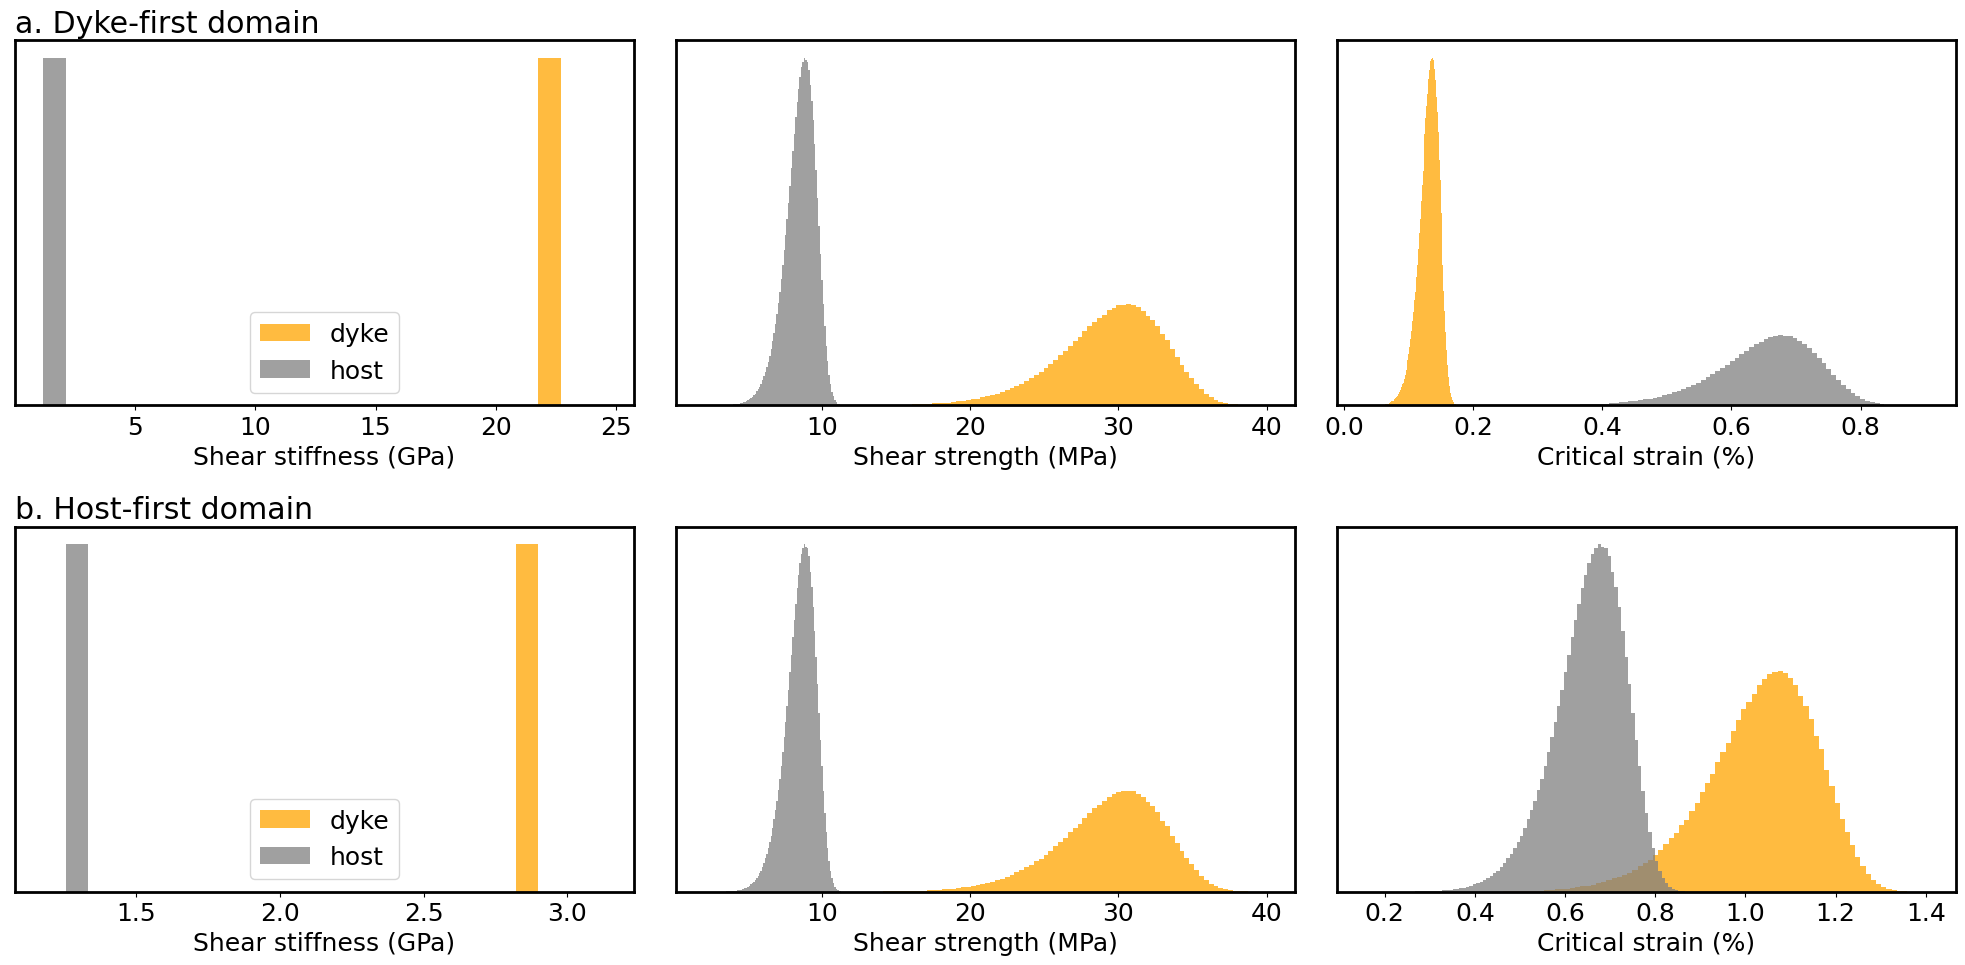

In [22]:
fig,ax = plt.subplots(2,3,figsize=(20,10))

for i,m in enumerate([fbm[0][-1], fbm[-1][-1]]):
    ax[i,0].hist(m.G0[:m.nA] / 1e9, bins=25, density=True, label='dyke', color='orange', alpha=0.75,
                 range=( np.min(m.G0)*0.9/1e9, np.max(m.G0)*1.1/1e9))
    ax[i,0].hist(m.G0[m.nA:] / 1e9, bins=25, density=True, label='host', color='gray', alpha=0.75,
                range=( np.min(m.G0)*0.9/1e9,np.max(m.G0)*1.1/1e9))
    ax[i,0].set_xlabel("Shear stiffness (GPa)")
    ax[i,0].legend()

    ax[i,1].hist(m.strength[:m.nA] / 1e6, bins=100, density=True, label='dyke', color='orange', alpha=0.75)
    ax[i,1].hist(m.strength[m.nA:] / 1e6, bins=100, density=True, label='host', color='gray', alpha=0.75)
    ax[i,1].set_xlabel("Shear strength (MPa)")

    fstrain = m.strength / m.G0
    ax[i,2].hist(100*fstrain[:m.nA], bins=100, density=True, label='dyke', color='orange', alpha=0.75)
    ax[i,2].hist(100*fstrain[m.nA:], bins=100, density=True, label='host', color='gray', alpha=0.75)
    ax[i,2].set_xlabel("Critical strain (%)")

ax[0,0].set_title("a. Dyke-first domain", loc='left')
ax[1,0].set_title("b. Host-first domain", loc='left')
for a in ax.ravel():
    a.set_yticks([])
    
fig.tight_layout()
fig.show()

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_43008/3573279668.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_43008/3573279668.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


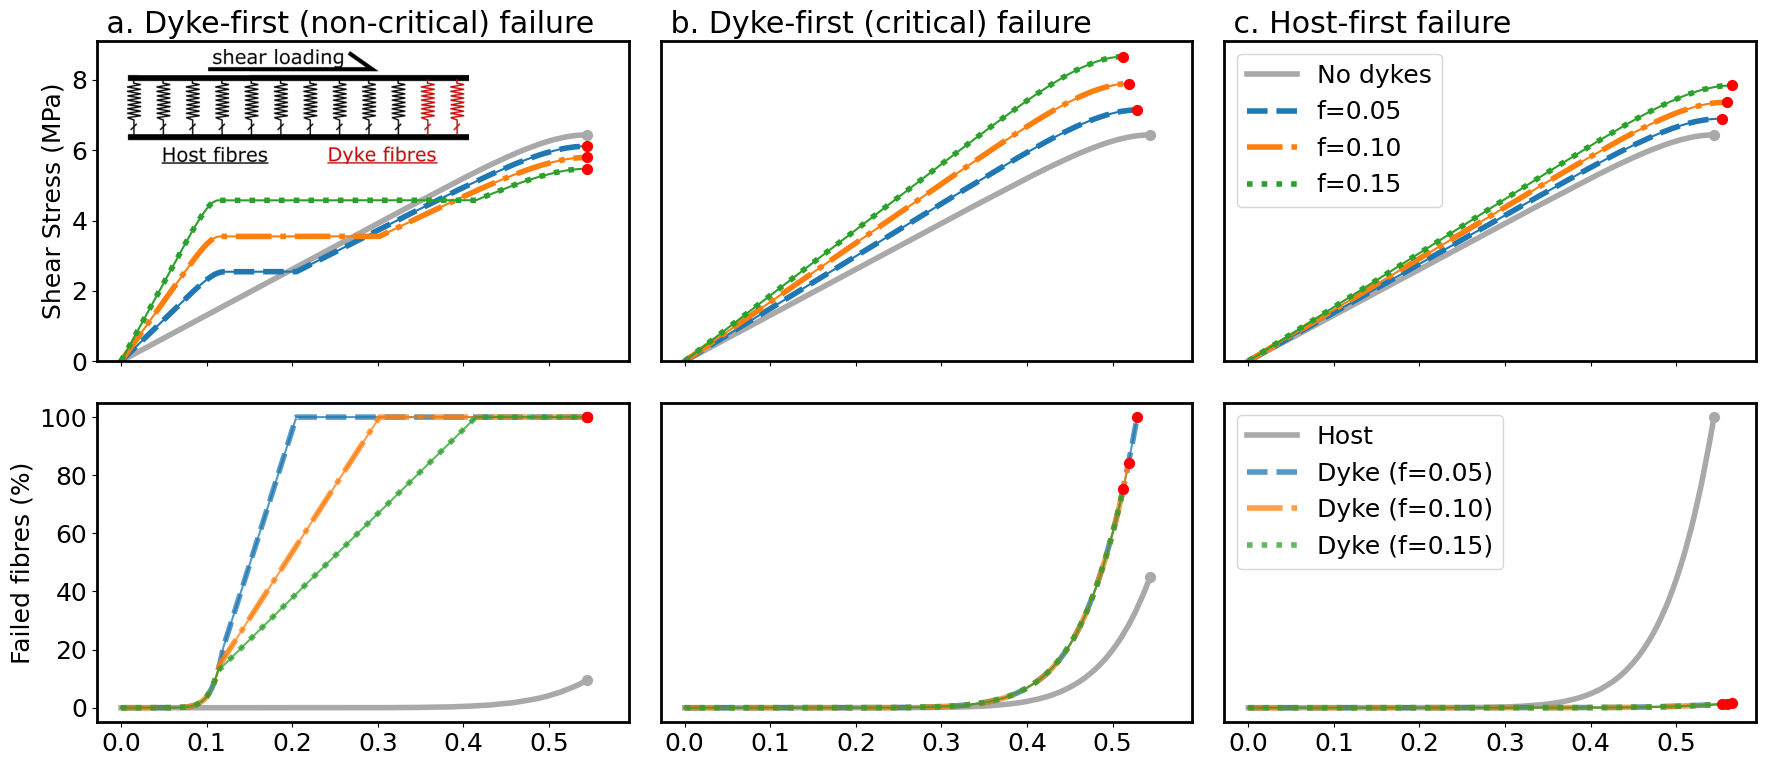

In [23]:
fig,ax = plt.subplots(2, len(fbm),figsize=(18,8), sharex=True)
for j, models in enumerate(fbm):
    
    # plot control model
    nmodels = len(models)
    ax[0,j].plot(control.strain*100, control.stress / 1e6, lw=4, color='darkgray', label='No dykes')
    ax[1,j].plot(control.strain*100, control.broken_B*100, lw=4, c='darkgray', label='Host')
    ax[0,j].scatter(control.strain[-1]*100, control.stress[-1]/1e6, s=50, color='darkgray', zorder=10)
    ax[1,j].scatter(control.strain[-1]*100, control.broken_B[-1]*100, s=50, color='darkgray', zorder=10)
    
    for i,(m,c,s) in enumerate(zip(models, 
                       ['tab:blue', 'tab:orange', 'tab:green'], 
                       ['--', '-.', ':'] )):

        # plot model
        n = "f=%.2f" % m.f
        ax[0,j].plot(m.strain*100, m.stress / 1e6, lw=4, c=c, ls=s, label=n)
        ax[0,j].plot(m.strain*100, m.stress / 1e6, lw=1.5, c=c)
        
        # plot cumulative failure
        ax[1,j].plot(m.strain*100, m.broken_A*100, lw=4, c=c, ls=s, label="Dyke (%s)"%n, alpha=0.75 )
        ax[1,j].plot(m.strain*100, m.broken_A*100, lw=1.5, c=c, alpha=0.75 )  
        
        # plot catastrophic failure point
        ax[0,j].scatter(m.strain[-1]*100, m.stress[-1]/1e6, s=50, color='r', zorder=10)
        ax[1,j].scatter(m.strain[-1]*100, m.broken_A[-1]*100, s=50, color='r', zorder=10)
    
ymx=np.max([a.get_ylim()[1] for a in ax[0,:]])
for a in ax[0,:]:
    a.set_ylim(0,ymx)
ax[0,2].legend()
ax[1,2].legend()

ax[0,0].set_ylabel('Shear Stress (MPa)')
ax[1,0].set_ylabel('Failed fibres (%)')
#ax[2,0].legend()
for a in ax[0,1:]:
    a.set_yticks([])
for a in ax[1, 1:]:
    a.set_yticks([])
    
ax[0,0].set_title(' a. Dyke-first (non-critical) failure', loc='left')
ax[0,1].set_title(' b. Dyke-first (critical) failure', loc='left')
ax[0,2].set_title(' c. Host-first failure', loc='left')

#plot model outline
ax1 = fig.add_axes([0.08, 0.64, 0.19, 0.4])
img = plt.imread("FBM_1.png")
ax1.imshow(img)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')

fig.tight_layout()
fig.show()

Also plot the power law distribution of failure size

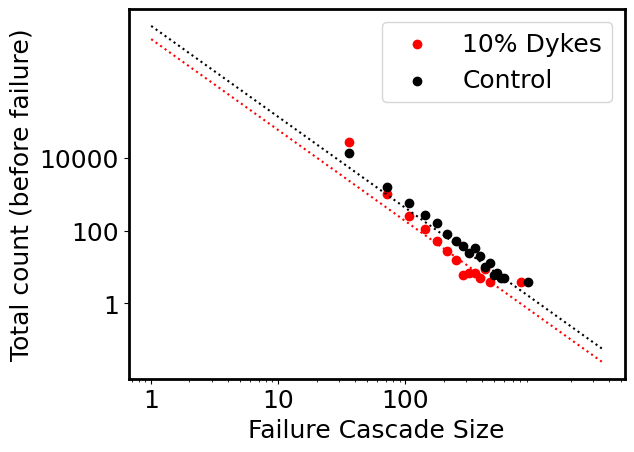

In [24]:
m = fbm[1][2] # use model representative of La Palma and with 0.1 dyke fraction
ae = np.hstack([m.ae_A[ m.ae_A > 1 ], m.ae_B[ m.ae_B > 1 ] ] ) # gather all failure cascades
ae_ctrl = control.ae_B[ control.ae_B > 1 ]

mx = np.max( [np.max(ae), np.max(ae_ctrl) ] )
for _ae,c,l in zip( [ae, ae_ctrl], ['r', 'k'], ['10% Dykes', 'Control']):
    counts, bins = np.histogram(_ae, range=(1,mx), bins=100 )
    plt.scatter(bins[1:][counts>3], counts[counts>3], color=c, label=l) # only plot cascades
                                                                        # for which we have >3 counts
                                                                        # (to avoid mess at cutoff limit)

    # plot trend line
    _m = -5/2
    _c = np.median(np.log(counts[counts>0])) - _m * np.median(np.log(bins[1:][counts>0]))
    _x = np.log( np.linspace(1., mx, 1000 ) )
    plt.plot( np.exp(_x), np.exp( _m*_x+_c ),color=c,linestyle=':')
    
    
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticks([10**0,10**1,10**2])
plt.gca().set_xticklabels(['1','10','100'])
plt.gca().set_yticks([10**0,10**2,10**4])
plt.gca().set_yticklabels(['1','100','10000'])
plt.xlabel("Failure Cascade Size")
plt.ylabel("Total count (before failure)")
plt.legend()
plt.show()

### 6. Visco-elastic fibre bunder models

In many rocks, stress dissipates over time due to non-elastic processes such as compaction, creep and other forms of plastic strain. This can be added to the fibre bundle model in a simple way using a Maxwell visco-elastic rheology that allows fibre stress to dissipate over time.

Visco-elasticity is already implemented in the above model; we just need to set the viscous term to something > 0. In the following we explore a fibre bundle model in which the host-rock deforms visco-elastically while the dykes remain linear elastic.

In [25]:
class MFBM( FBM ):
    """
    Maxwell fibre bundle model
    """
    
    def __init__( self, dyke_props, host_props, f=0.1, N=10000, seed=42 ):
        
        # setup normal FBM
        super().__init__( dyke_props, host_props, f=f, N=N, seed=seed )
        
        # also get viscous properties
        self.mu_A = mu_A = dyke_props.get('mu', np.inf) # viscous relaxation term
        self.mu_B = mu_B = host_props.get('mu', np.inf) # N.B. inf is used to denote purely elastic behaviour
        
        # and build array per-fibre
        self.mu = np.hstack([  [mu_A]*self.nA, # A-type fibers
                               [mu_B]*(self.N-self.nA)])  #B-type fibers
        

    def run( self, initial_stress=2.0, r=1e3, final_time = 25, ts=0.1 ):
        """
        Run this FBM model and store results. 
        
        **Arguments**:
        - initial_stress = the initial bulk shear load (MPa) that the network is subject to prior ot allowing
                            viscous relaxation. Default is 
        - r = the loading increment (step) in Pa during the initialisatin stage.
        - final_time = how long to run the model for (in years).
        - ts = the timestep of the model (in years). Default is 10.
        """
        
        # convert timestep from years to seconds
        ts = ts * 3.154e7
        final_time = final_time*3.154e7
        
        # use elastic model to initialise shear stresses (approximately - this assumes
        # no fibre breakages)
        _stress = initial_stress
        _strain = _stress / np.mean(self.G0)
        
        # calculate per-fibre failure strains and check nothing broke yet
        self.fstrain = self.strength / self.G0  # critical (elastic) strain of each fibre
        assert (_strain < self.fstrain).any(), "Error - MFBM could not support initial load."
                
        #setup output vars
        self.strain = [_strain]
        self.stress = [_stress]
        self.ae_A = [0]
        self.ae_B = [0]
        self.broken_A = [0] # fraction of broken A fibres
        self.broken_B = [0] # fraction of broken B fibres
        self.G = self.G0.copy()
        
        # initialise array of broken fibres (all intact so far)
        self.intact = np.array([True] * self.N) 
        
        # now run time-stepping model
        self.time = [0]
        _load = initial_stress # model now runs at constant load
        _viscous_strain = np.zeros_like( self.G ) # initialise at 0 viscous strain
        self.catastrophic = False
        while (self.intact.any()) and (self.time[-1] < final_time ):
            _t = self.time[-1] + ts
            
            _ae_A = 0
            _ae_B = 0
            
            # apply permanent (viscous) strain of intact host-fibers
            # based on their per-fibre stress
            _stress = ( _strain - _viscous_strain )*self.G
            _viscous_strain += (_stress/self.mu)*ts
            
            # iterate elastic part until stable (macroscopic load is met)
            _ae_A = 0
            _ae_B = 0
            stable = False
            while not stable:
                # compute residual stress (that must be accomodated purely elastically)
                # and associated additional elastic strain
                _residual = _load - np.mean(_stress)
                _elastic_strain = _residual / np.mean(self.G) # bulk additional elastic strain
                
                # update per-fibre stresses
                _stress = (_strain - _viscous_strain)*self.G + _elastic_strain * self.G
                
                # and per-fibre strains
                _strain = _strain + _elastic_strain
                
                # which fibres broke?
                broken = _stress > self.strength
                if broken.any():
                    # store ae
                    _ae_A += np.sum( broken[0:self.nA] )
                    _ae_B += np.sum( broken[self.nA:] )

                    # break fibers
                    self.G[0:self.nA][ broken[0:self.nA] ] *= self.a_A
                    self.G[self.nA:][ broken[self.nA:] ] *= self.a_B
                    self.fstrain[broken] = np.inf
                    self.intact[broken] = False
                
                # bundle is stable
                else:
                    _residual = _load - np.mean(_stress)
                    if np.abs(_residual) < 1e-3:
                        stable = True
                    
                # check catastrophic failure!
                if not self.intact.any():
                    self.catastrophic = True
                    break
                    
            # store data then go to next timestep
            if self.intact.any():
                self.strain.append(_strain)
                self.stress.append(np.mean(_stress))
                self.ae_A.append(_ae_A)
                self.ae_B.append(_ae_B)
                self.broken_A.append( 1 - (np.sum(self.intact[:self.nA]) / self.nA) )
                self.broken_B.append( 1 - (np.sum(self.intact[self.nA:]) / (self.N-self.nA) ) )
                self.time.append(_t)
                # print("step")
                
        # convert lists to arrays
        self.strain = np.array(self.strain)
        self.stress = np.array(self.stress)
        self.ae_A = np.array(self.ae_A)
        self.ae_B = np.array(self.ae_B)
        self.broken_A = np.array(self.broken_A)
        self.broken_B = np.array(self.broken_B)
        self.time = np.array(self.time) / 3.154e7
        
        

In [26]:
# shear stresses to trial
#dip = np.array( [ np.deg2rad(i) for i in [5,10,15,20,25] ] )
#tau = 0.5*(S1-S3) * np.sin( 2 * dip ) * 1e6
tau = np.array([2.0, 2.5, 3.25, 3.75, ])*1e6

# define strong and weak host properties
strong_host = host # use estimates for standard pyroclastic layers
weak_host = host.copy()
weak_host['tcrit'] = strong_host['tcrit'] / 2.
#weak_host['G'] = strong_host['G'] / 2

# set viscocity
strong_host['mu'] = weak_host['mu'] = 1e17

# define dyke properties (buest guess for L Palma)
d = dyke[1]

# dyke fraction
f = 0.1

/var/folders/md/hll0db4s00s78s6s9j4rlt0w0000gq/T/ipykernel_43008/3860877851.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


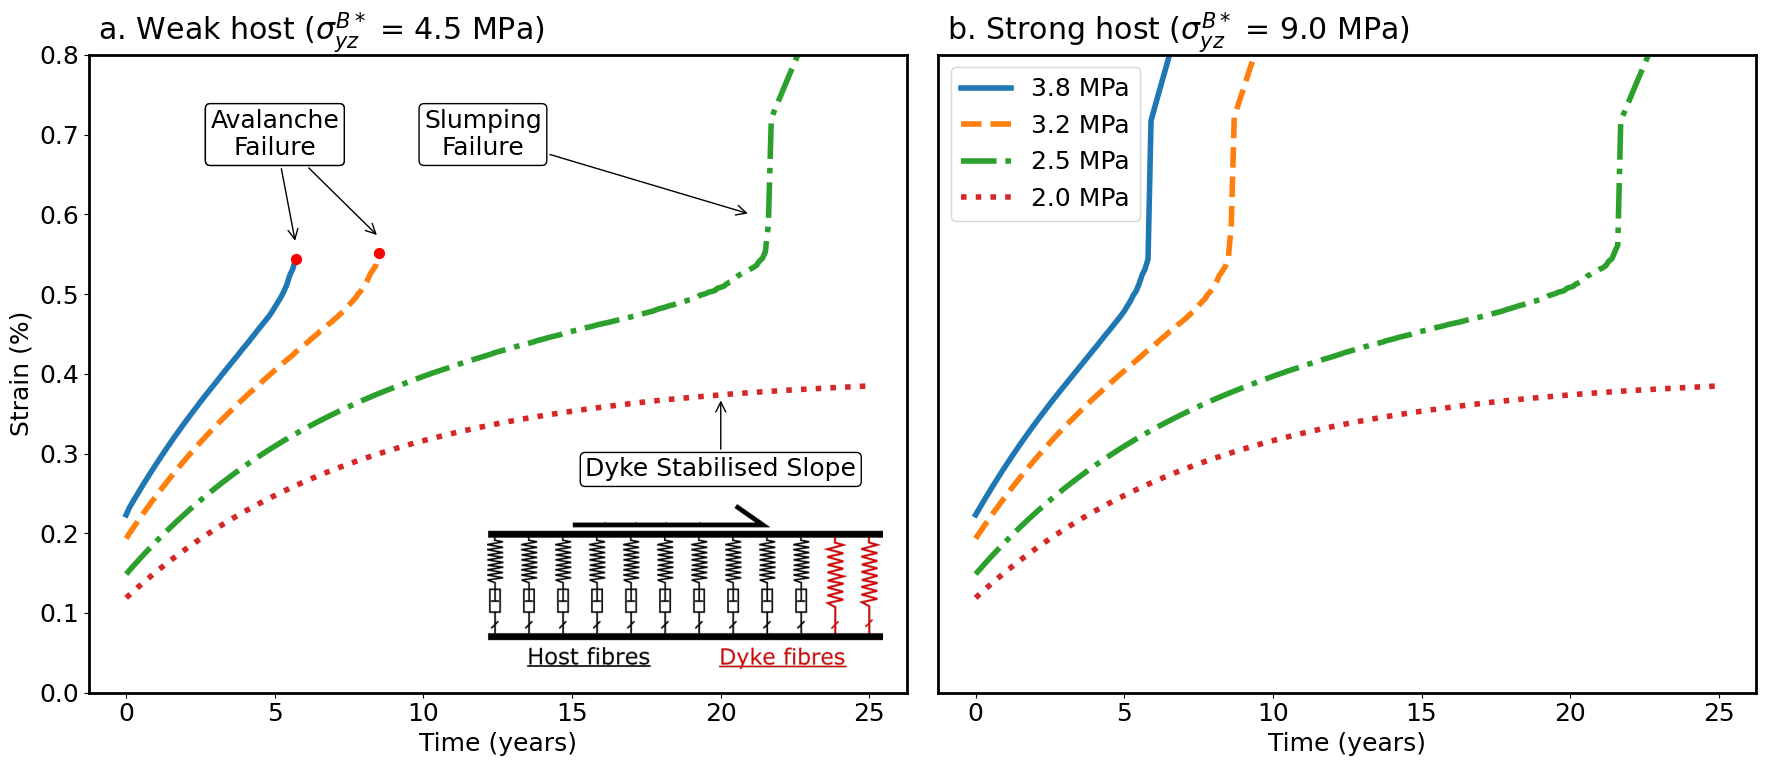

In [27]:
# run models and plot
fig,ax = plt.subplots(1,2,figsize=(18,8) )

for i,h in enumerate([weak_host, strong_host]):  
    # print(h)
    for t,ls in zip( tau[::-1], ['-', '--', '-.', ':']): # different loading angles
        M = MFBM( d, h , f=f )
        M.run( initial_stress=t ) 
        
        ax[i].plot(M.time, M.strain * 100, lw=4, label="%.1f MPa"%(t/1e6), ls=ls )
        if M.catastrophic:
            ax[i].scatter(M.time[-1], M.strain[-1]*100, s=50, color='r', zorder=10)
            ax[i].annotate("Avalanche\nFailure", xy=(M.time[-1],M.strain[-1]*100 + 0.02),xytext=(5,0.7),arrowprops=dict(arrowstyle='->'),
               verticalalignment='center',horizontalalignment='center',zorder=15,bbox=bbox_props)

ax[0].set_title(" a. Weak host ($\sigma^{B*}_{yz}$ = %.1f MPa)"%(weak_host['tcrit']/1e6), loc='left')
ax[1].set_title(" b. Strong host ($\sigma^{B*}_{yz}$ = %.1f MPa)"%(strong_host['tcrit']/1e6), loc='left')

ax[0].set_ylim(0,0.8)
ax[1].set_ylim(0,0.8)
ax[1].set_yticks([])
ax[1].legend()

ax[0].set_ylabel("Strain (%)")
ax[0].set_xlabel("Time (years)")
ax[1].set_xlabel("Time (years)")


# add labels
ax[0].annotate("Slumping\nFailure", xy=(21,0.6),xytext=(12,0.7),arrowprops=dict(arrowstyle='->'),
               verticalalignment='center',horizontalalignment='center',zorder=15,bbox=bbox_props)
ax[0].annotate("Dyke Stabilised Slope", xy=(20,0.37),xytext=(20,0.28),arrowprops=dict(arrowstyle='->'),
               verticalalignment='center',horizontalalignment='center',zorder=15,bbox=bbox_props)


#plot model outline
ax1 = fig.add_axes([0.28, 0.035, 0.22, 0.42])
img = plt.imread("FBM_2.png")
ax1.imshow(img)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')


fig.tight_layout()
plt.show()